In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    MaxPooling2D,
    Conv2D,
    Dropout,
    BatchNormalization,
)

import json

from src.kerasCNN import *
from src.augmentations.CustomAugmentations import CustomAugmentationsTF

import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import pickle

from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm.notebook import tqdm

import numpy as np
import random
import os
try:
    os.mkdir("../models")
except:
    pass

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"
keras.utils.set_random_seed(42)

In [2]:
models = {
    'BESTClassicCNN': {
        'path': 'models/BESTClassicCNN_aug_flip0.5_gauss_noise0.5_2.h5',
        'acc' : 0.65168,
    },
    'BESTEfficientNet': {
        'path': 'models/EfficientNet_13epochs_aug_flip0.5_4.h5',
        'acc': 0.77066,
    },
    'BESTResNet': {
        'path': 'models/ResNet50_aug_flip0.5_3.h5',
        'acc': 0.67122,
    },
}

In [3]:
print("Loading model classicCNN")
classicCNN = keras.models.load_model(models['BESTClassicCNN']['path'])
print("Loading model EfficientNet")
efficientNet = keras.models.load_model(models['BESTEfficientNet']['path'])
print("Loading model ResNet")
resNet = keras.models.load_model(models['BESTResNet']['path'])

Loading model classicCNN
Loading model EfficientNet
Loading model ResNet


In [4]:
batch_size = 64
height, width = 32, 32

In [5]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
                "../data/CINIC10/test",
                labels="inferred",
                label_mode="int",
                class_names=None,
                color_mode="rgb",
                batch_size=batch_size,
                image_size=(height, width),
                shuffle=False,
            )

Found 90000 files belonging to 10 classes.


In [6]:
model_weights = [models['BESTClassicCNN']['acc'], models['BESTEfficientNet']['acc'], models['BESTResNet']['acc']]
model_weights = np.array(model_weights) / np.sum(model_weights)
model_weights

array([0.3112784 , 0.36810982, 0.32061178])

In [7]:
# make predictions
preds_models = {
    'classicCNN': [],
    'efficientNet': [],
    'resNet': [],
}

preds_models['classicCNN'] = classicCNN.predict(test_set)
preds_models['efficientNet'] = efficientNet.predict(test_set)
preds_models['resNet'] = resNet.predict(test_set)



1407/1407 [==============================] - 15s 11ms/step


In [8]:
# make the ensemble prediction
ensemble_preds = np.zeros((90000, 10))
for i, model in enumerate(models):
    ensemble_preds += model_weights[i] * preds_models[list(preds_models.keys())[i]]

ensemble_preds = np.argmax(ensemble_preds, axis=1)
ensemble_preds

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [9]:
# get the true labels
classes = test_set.class_names
test_labels = list()
for images, labels in test_set:
    class_labels = [int(label) for label in labels]
    test_labels.extend(class_labels)
test_labels = np.array(test_labels)

In [10]:
test_labels

array([0, 0, 0, ..., 9, 9, 9])

In [11]:
# get the accuracy
accuracy = accuracy_score(test_labels, ensemble_preds)
accuracy

0.7653777777777778

In [12]:
conf_mat = confusion_matrix(test_labels, ensemble_preds)
accuracy = accuracy_score(test_labels, ensemble_preds)
class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)

conf_mat

array([[7654,  128,  169,   75,   73,   43,   22,   82,  567,  187],
       [ 135, 6852,   33,   48,   41,   64,   30,   79,  225, 1493],
       [ 378,   22, 6467,  432,  483,  346,  568,  117,  159,   28],
       [  95,   33,  333, 6021,  588, 1145,  442,  190,   86,   67],
       [ 136,   26,  367,  507, 6727,  442,  208,  433,  110,   44],
       [  84,   52,  344, 1428,  974, 5223,  197,  535,   92,   71],
       [  36,   19,  322,  414,  117,  135, 7888,   19,   33,   17],
       [  88,   28,   96,  207,  628,  359,   22, 7368,  103,  101],
       [ 454,  200,  162,  109,   99,   81,   69,   65, 7544,  217],
       [ 159, 1053,   37,   75,   74,   60,   35,   94,  273, 7140]],
      dtype=int64)

In [13]:
# read labels from labels.json
labels = dict()
with open('summaries/labels.json') as f:
    labels = json.load(f)
# reverse the dictionary
labels = {v: k for k, v in labels.items()}
labels

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

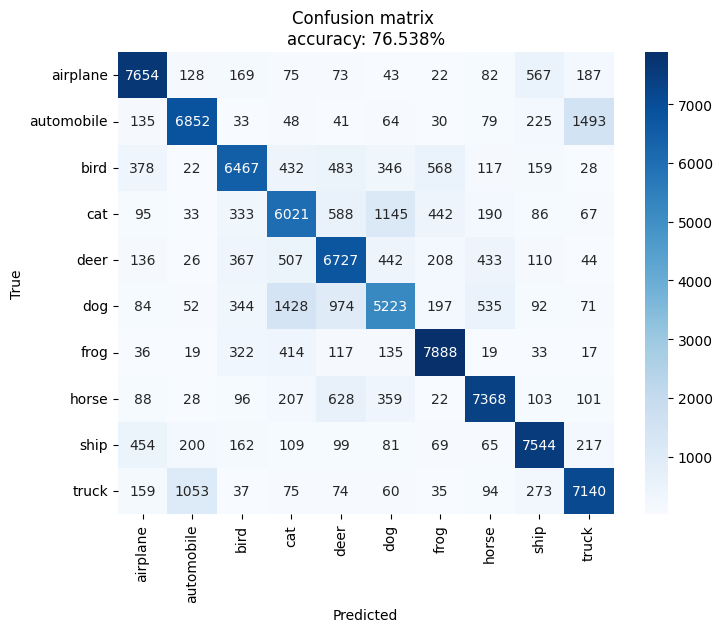

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Confusion matrix \naccuracy: {accuracy*100:.3f}%')
ax.set_xticks(np.arange(10) + 0.5)
ax.set_xticklabels([labels[i] for i in range(10)], rotation=90)
ax.set_yticks(np.arange(10) + 0.5)
ax.set_yticklabels([labels[i] for i in range(10)], rotation=0)
plt.show()

In [15]:
class_accuracy

array([0.85044444, 0.76133333, 0.71855556, 0.669     , 0.74744444,
       0.58033333, 0.87644444, 0.81866667, 0.83822222, 0.79333333])

In [22]:
# classic CNN class accuracy
# read data from pickle
with open('results/CLASS_ACCURACY_BESTClassicCNN_aug_flip0.5_gauss_noise0.5.pkl', 'rb') as f:
    resnet_class_accuracy = pickle.load(f)
resnet_class_accuracy[2]

array([0.76811111, 0.69233333, 0.52577778, 0.59655556, 0.62855556,
       0.45122222, 0.71288889, 0.70644444, 0.73166667, 0.70322222])

In [25]:
# resNet class accuracy
# read data from pickle
with open('results/CLASS_ACCURACY_ResNet50_aug_flip0.5.pkl', 'rb') as f:
    resnet_class_accuracy = pickle.load(f)
resnet_class_accuracy[3]

array([0.785     , 0.64877778, 0.627     , 0.58744444, 0.64144444,
       0.49      , 0.82266667, 0.71011111, 0.67666667, 0.72311111])

In [26]:
# EfficientNet class accuracy
# read data from pickle
with open('results/CLASS_ACCURACY_EfficientNet_13epochs_aug_flip0.5.pkl', 'rb') as f:
    resnet_class_accuracy = pickle.load(f)
resnet_class_accuracy[4]

array([0.84077778, 0.78644444, 0.72988889, 0.62822222, 0.73977778,
       0.59833333, 0.89033333, 0.83922222, 0.87411111, 0.77944444])